In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
from datetime import timedelta
import datetime

# Please read, my idea was to classify the data into three cateogries: "UP", "DOWN", "NEUTRAL"
# UP - the price of the stock is up MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# DOWN - the price of the stock is down MINIMUM_GAIN percent after LOOK_AHEAD_DAYS days.
# NEUTRAL - the price of stock is did not rise or fall past the MINIMUM_GAIN threshhold
#
# EXAMPLE: LOOK_AHEAD_DAYS = 30, MINIMUM_GAIN = .05 (5%). If stock is up over 5% ore more after 30 days, 
# we mark it as 'UP'. If the stock is down 5% or more after 30 days, we mark it as 'DOWN'. If the stock
# is neither up nor down 5%, then we mark it as 'NEUTRAL'

# MINIMUM_GAIN = .05 #minimal gain to be considered up or down for classification, UNUSED NOW

LOOK_BACK_DAYS = 30 #number of days into the past we would like to take into account
LOOK_AHEAD_DAYS = 1 #number of days into the future we are trying to predict

class Utilities:

    @staticmethod
    def getData(ticker, start_date, end_date):
        try:
            stock_data = data.DataReader(ticker,
                                         'yahoo',
                                         start_date,
                                         end_date)
            return stock_data
        except RemoteDataError:
            print('No data found for {t}'.format(t=ticker))
#just get the btc price points from the past year
start_date = datetime.datetime.now() - timedelta(365)
end_date = datetime.datetime.now() - timedelta(1)
btc_df = Utilities.getData('BTC-USD', str(start_date.strftime('%Y-%m-%d')), str(end_date.strftime('%Y-%m-%d')))
btc_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-10,11523.579102,11248.294922,11349.740234,11523.579102,1.577437e+10,11523.579102
2019-08-11,11528.189453,11320.951172,11528.189453,11382.616211,1.364720e+10,11382.616211
2019-08-12,11420.049805,10830.327148,11385.052734,10895.830078,1.668150e+10,10895.830078
2019-08-13,10889.556641,10028.135742,10889.487305,10051.704102,1.999084e+10,10051.704102
2019-08-14,10437.411133,9675.316406,10038.421875,10311.545898,2.289912e+10,10311.545898
...,...,...,...,...,...,...
2020-08-05,11902.335938,11598.713867,11749.871094,11779.773438,2.340074e+10,11779.773438
2020-08-06,11898.038086,11408.593750,11778.894531,11601.472656,2.313231e+10,11601.472656
2020-08-07,11800.064453,11558.431641,11604.553711,11754.045898,1.757206e+10,11754.045898


In [3]:
def createLookBackCols():
    for i in range(LOOK_BACK_DAYS):
        num_rows= btc_df.shape[0]
        num_cols= btc_df.shape[1]
        btc_df.insert(loc = num_cols, column = 'High_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Low_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Open_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Volume_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        btc_df.insert(loc = num_cols, column = 'Adj Close_Past_' + str(i + 1), value = ['N/A'] * num_rows)
        
createLookBackCols() #create additional look back columns
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
    if (current_date - start_date).days >= LOOK_BACK_DAYS - 1:
        for i in range(LOOK_BACK_DAYS):
            index = i + 1
            look_back_date = current_date - timedelta(days=index)
            
            while True: #we need to keep subtracting days to the look_back_date because there is no index for that day
                if look_back_date in btc_df.index:
                    break
                look_back_date = look_back_date - timedelta(days=1)
            
            btc_df.at[pd.Timestamp(current_date), 'High_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'High']
            btc_df.at[pd.Timestamp(current_date), 'Low_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Low']
            btc_df.at[pd.Timestamp(current_date), 'Open_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Open']
            btc_df.at[pd.Timestamp(current_date), 'Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Close']
            btc_df.at[pd.Timestamp(current_date), 'Volume_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Volume']
            btc_df.at[pd.Timestamp(current_date), 'Adj Close_Past_' + str(index)] = btc_df.at[pd.Timestamp(look_back_date), 'Adj Close']

btc_df = btc_df[btc_df.High_Past_1 != 'N/A']
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,...,Close_Past_29,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-10,10215.948242,9980.776367,10123.035156,10178.372070,1.542806e+10,10178.372070,10116,1.49068e+10,10116,10336.4,...,10895.8,11385.1,10830.3,11420,11382.6,1.36472e+10,11382.6,11528.2,11321,11528.2
2019-09-11,10442.253906,10099.242188,10176.819336,10410.126953,1.532356e+10,10410.126953,10178.4,1.54281e+10,10178.4,10123,...,10051.7,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420
2019-09-12,10441.489258,10226.596680,10415.362305,10360.546875,1.410986e+10,10360.546875,10410.1,1.53236e+10,10410.1,10176.8,...,10311.5,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6
2019-09-13,10422.133789,10291.694336,10345.403320,10358.048828,1.346871e+10,10358.048828,10360.5,1.41099e+10,10360.5,10415.4,...,10374.3,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4
2019-09-14,10387.035156,10313.092773,10356.465820,10347.712891,1.204343e+10,10347.712891,10358,1.34687e+10,10358,10345.4,...,10231.7,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-05,11902.335938,11598.713867,11749.871094,11779.773438,2.340074e+10,11779.773438,11747,2.44113e+10,11747,11203.8,...,9428.33,9253.02,9249.5,9450.34,9252.28,1.38397e+10,9252.28,9349.16,9201.82,9360.62
2020-08-06,11898.038086,11408.593750,11778.894531,11601.472656,2.313231e+10,11601.472656,11779.8,2.34007e+10,11779.8,11749.9,...,9277.97,9427.99,9235,9431.38,9428.33,1.97024e+10,9428.33,9253.02,9249.5,9450.34
2020-08-07,11800.064453,11558.431641,11604.553711,11754.045898,1.757206e+10,11754.045898,11601.5,2.31323e+10,11601.5,11778.9,...,9278.81,9273.36,9118,9287.47,9277.97,1.80007e+10,9277.97,9427.99,9235,9431.38


In [4]:
btc_df = btc_df.assign(MonthTrend=lambda x: "N/A") #introduce new column that will be the trend we are predicting
btc_df = btc_df.loc[~btc_df.index.duplicated(keep='first')] #delete all duplicate indices

#Populate the classification column MonthTrend
for index, row in btc_df.iterrows():
    current_date = index.to_pydatetime()
   
    if (end_date - current_date).days > LOOK_AHEAD_DAYS:
        look_ahead_date = current_date + timedelta(days=LOOK_AHEAD_DAYS)
        
        while True: #we need to keep adding days to the look_ahead_date because there is no index for that day
            if look_ahead_date in btc_df.index:
                break
            look_ahead_date = look_ahead_date + timedelta(days=1)
        
        #Here we check if the open price in the future is higher than today's open price.
        if btc_df.loc[pd.Timestamp(look_ahead_date)]['Open'] > btc_df.loc[index]['Open']:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'UP'
        else:
            btc_df.at[pd.Timestamp(look_ahead_date), 'MonthTrend'] = 'DOWN'
            
#Now delete all columns that have a MonthTrend value of N/A
btc_df = btc_df[btc_df.MonthTrend != 'N/A']

#Data is now fully processed and ready to be trained on the machine learning model
#There are 3 values for MonthTrend: UP, DOWN,NEUTRAL
btc_df

,High,Low,Open,Close,Volume,Adj Close,Adj Close_Past_1,Volume_Past_1,Close_Past_1,Open_Past_1,...,Open_Past_29,Low_Past_29,High_Past_29,Adj Close_Past_30,Volume_Past_30,Close_Past_30,Open_Past_30,Low_Past_30,High_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-11,10442.253906,10099.242188,10176.819336,10410.126953,1.532356e+10,10410.126953,10178.4,1.54281e+10,10178.4,10123,...,10889.5,10028.1,10889.6,10895.8,1.66815e+10,10895.8,11385.1,10830.3,11420,UP
2019-09-12,10441.489258,10226.596680,10415.362305,10360.546875,1.410986e+10,10360.546875,10410.1,1.53236e+10,10410.1,10176.8,...,10038.4,9675.32,10437.4,10051.7,1.99908e+10,10051.7,10889.5,10028.1,10889.6,UP
2019-09-13,10422.133789,10291.694336,10345.403320,10358.048828,1.346871e+10,10358.048828,10360.5,1.41099e+10,10360.5,10415.4,...,10319.4,9855.48,10524.3,10311.5,2.28991e+10,10311.5,10038.4,9675.32,10437.4,DOWN
2019-09-14,10387.035156,10313.092773,10356.465820,10347.712891,1.204343e+10,10347.712891,10358,1.34687e+10,10358,10345.4,...,10358.7,10086.7,10452.6,10374.3,2.02282e+10,10374.3,10319.4,9855.48,10524.3,UP
2019-09-15,10386.867188,10189.744141,10347.222656,10276.793945,1.516017e+10,10276.793945,10347.7,1.20434e+10,10347.7,10356.5,...,10233,10119.1,10487.1,10231.7,1.3778e+10,10231.7,10358.7,10086.7,10452.6,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-04,11786.617188,11158.285156,11203.823242,11747.022461,2.441125e+10,11747.022461,11246.3,2.02717e+10,11246.3,11043.8,...,9349.16,9201.82,9360.62,9375.47,1.78893e+10,9375.47,9072.85,9058.66,9375.47,UP
2020-08-05,11902.335938,11598.713867,11749.871094,11779.773438,2.340074e+10,11779.773438,11747,2.44113e+10,11747,11203.8,...,9253.02,9249.5,9450.34,9252.28,1.38397e+10,9252.28,9349.16,9201.82,9360.62,UP
2020-08-06,11898.038086,11408.593750,11778.894531,11601.472656,2.313231e+10,11601.472656,11779.8,2.34007e+10,11779.8,11749.9,...,9427.99,9235,9431.38,9428.33,1.97024e+10,9428.33,9253.02,9249.5,9450.34,UP


In [5]:
def generateFeatures(features):
    complete_features = []
    for feature in features:
        complete_features.append(feature)
        for i in range(LOOK_BACK_DAYS):
            complete_features.append(feature + "_Past_" + str(i + 1))
    return complete_features

features = generateFeatures(['Close','Open'])
features.append('MonthTrend')

# selecting the important feature open close
btc = btc_df[features]
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,...,Open_Past_22,Open_Past_23,Open_Past_24,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-11,10410.126953,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,...,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,11385.1,UP
2019-09-12,10360.546875,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,...,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,10889.5,UP
2019-09-13,10358.048828,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,...,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,10038.4,DOWN
2019-09-14,10347.712891,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,...,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,10319.4,UP
2019-09-15,10276.793945,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,...,10160.7,10407.6,10136.3,10142.5,10764.6,10916.3,10350.3,10233,10358.7,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-04,11747.022461,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,...,9238.7,9277.21,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,9072.85,UP
2020-08-05,11779.773438,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,...,9241.9,9238.7,9277.21,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,UP
2020-08-06,11601.472656,11779.8,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,...,9191.98,9241.9,9238.7,9277.21,9241.05,9277.51,9273.36,9427.99,9253.02,UP


In [6]:
# load pre-fetched news sentiment data and add in the dataframe
import pickle
import warnings
import os
warnings.filterwarnings('ignore')
f = open(os.path.join(os.getcwd(), "polaritys_score.pkl"), "rb")
#f = open("./drive/My Drive/final_project/polaritys_score.pkl", "rb")
polaritys_file = pickle.load(f)
f.close()

polaritys_df = pd.DataFrame(index=list(polaritys_file.keys())[::-1], columns=['neg', 'neu', 'pos'])
for date in list(polaritys_file.keys())[::-1]:
  for polar in ['neg', 'neu', 'pos']:
    polaritys_df.loc[date][polar] = polaritys_file[date][polar]

## keep data only after 2019-09-09 and remove data on 2020-08-03(error in Yahoo?)
btc_index_str = [btc_index.strftime('%Y-%m-%d') for btc_index in list(btc.index)]

sentiment_data = polaritys_df.loc[btc_index_str]
sentiment_data.columns = ['negative', 'neutral', 'positive']

## add sentiment in the dataframe
btc[['negative', 'neutral', 'positive']] = sentiment_data[['negative', 'neutral', 'positive']]
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,...,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend,negative,neutral,positive
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-11,10410.126953,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,...,10233,10358.7,10319.4,10038.4,10889.5,11385.1,UP,0.0484984,0.888504,0.0629979
2019-09-12,10360.546875,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,...,10350.3,10233,10358.7,10319.4,10038.4,10889.5,UP,0.0588,0.8413,0.0999
2019-09-13,10358.048828,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,...,10916.3,10350.3,10233,10358.7,10319.4,10038.4,DOWN,0.0439319,0.879837,0.0762308
2019-09-14,10347.712891,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,...,10764.6,10916.3,10350.3,10233,10358.7,10319.4,UP,0.0253,0.9104,0.0643
2019-09-15,10276.793945,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,...,10142.5,10764.6,10916.3,10350.3,10233,10358.7,DOWN,0.0291676,0.881429,0.089403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-04,11747.022461,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,...,9277.51,9273.36,9427.99,9253.02,9349.16,9072.85,UP,0.05575,0.8895,0.05475
2020-08-05,11779.773438,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,...,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,UP,0.022,0.902368,0.0756316
2020-08-06,11601.472656,11779.8,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,...,9277.21,9241.05,9277.51,9273.36,9427.99,9253.02,UP,0.0257778,0.895,0.0792222


In [7]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
Y = btc['MonthTrend']
le =LabelEncoder()
Y = le.fit_transform(Y)
X = btc.drop(['MonthTrend'], axis=1)
X = StandardScaler().fit_transform(X)
# Create training and testing datasets that are appropriate for time series data
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=2)
train_size_perc = 0.7
n_time, n_features = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[(train_size+LOOK_AHEAD_DAYS):], Y[(train_size+LOOK_AHEAD_DAYS):]

In [8]:
# decision tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(random_state=45)
param_grid = {'splitter': ["best","random"],  
              'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
             'max_leaf_nodes':[10,50,None]}  
grid =  GridSearchCV(model_tree,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
grid.fit(X_train,Y_train)
model_tree = grid.best_estimator_
tree_error_rate = 1 - model_tree.score(X_test,Y_test)
tree_error_rate

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done 5760 out of 5760 | elapsed:    2.7s finished


0.4591836734693877

In [9]:
model_tree.score(X_train, Y_train)

0.8793103448275862

In [10]:
#confusion matrix and classification for testing
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc
import matplotlib.pylab as plt
prediction = model_tree.predict(X_test)
print(confusion_matrix(Y_test, prediction))

[[35  8]
 [37 18]]


In [11]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.49      0.81      0.61        43
           1       0.69      0.33      0.44        55

    accuracy                           0.54        98
   macro avg       0.59      0.57      0.53        98
weighted avg       0.60      0.54      0.52        98



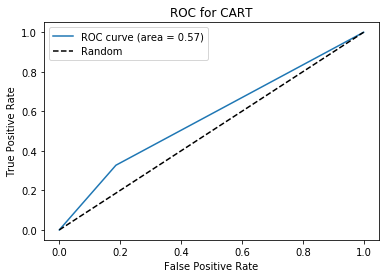

In [12]:
# Plot the ROC curve

def plot_roc(Y_test,Y_pred, classifier_name):
    fpr, tpr, _ = roc_curve(Y_test,Y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC for " + classifier_name)
    plt.legend(loc="best")
    plt.show()
plot_roc(Y_test,prediction, "CART")

In [13]:
# random forest
from sklearn.ensemble import RandomForestClassifier
model_random = RandomForestClassifier(random_state=42)
param_grid = {
             'min_samples_split': [2,4,6,8],
             'criterion':["gini","entropy"],
             'max_features':["auto", "sqrt", "log2"],
              'max_depth':[6,8,10,20],
              'min_samples_leaf':[1,2,4,6],
             'max_leaf_nodes':[10,50]}  
random_grid =  GridSearchCV(model_random,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
random_grid.fit(X_train,Y_train)
model_random = random_grid.best_estimator_
tree_error_rate =1 - model_random.score(X_test,Y_test)
tree_error_rate

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done 7092 tasks      | elapsed:   11.5s
[Parallel(n_jobs=6)]: Done 7680 out of 7680 | elapsed:   12.5s finished


0.5204081632653061

In [14]:
model_random.score(X_train, Y_train)

0.9267241379310345

In [15]:
new_prediction = model_random.predict(X_test)
print(confusion_matrix(Y_test, new_prediction))

[[31 12]
 [39 16]]


In [16]:
print(classification_report(Y_test, new_prediction))

              precision    recall  f1-score   support

           0       0.44      0.72      0.55        43
           1       0.57      0.29      0.39        55

    accuracy                           0.48        98
   macro avg       0.51      0.51      0.47        98
weighted avg       0.52      0.48      0.46        98



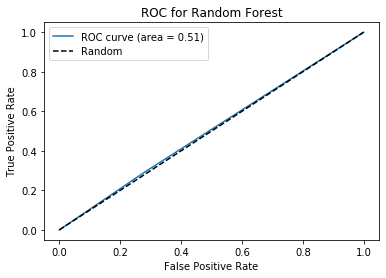

In [17]:
plot_roc(Y_test,new_prediction, "Random Forest")

In [18]:
# linear svm
from sklearn.svm import LinearSVC
model_svm = LinearSVC(random_state=42)
param_grid = {
             'C': [1,2,4,6,8,10],
             'loss':["hinge","squared_hinge"],
             'fit_intercept':[True,False],
              'class_weight':["balanced",None]}  
svm_grid =  GridSearchCV(model_svm,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
svm_grid.fit(X_train,Y_train)
model_svm = svm_grid.best_estimator_
svm_error_rate =1 - model_svm.score(X_test,Y_test)
svm_error_rate

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=6)]: Done 480 out of 480 | elapsed:    1.0s finished


0.09183673469387754

In [19]:
model_svm.score(X_train, Y_train)

0.9956896551724138

In [20]:
svm_prediction = model_svm.predict(X_test)
print(confusion_matrix(Y_test, svm_prediction))

[[41  2]
 [ 7 48]]


In [21]:
print(classification_report(Y_test, svm_prediction))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90        43
           1       0.96      0.87      0.91        55

    accuracy                           0.91        98
   macro avg       0.91      0.91      0.91        98
weighted avg       0.91      0.91      0.91        98



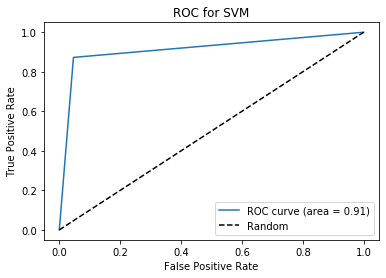

In [22]:
plot_roc(Y_test,svm_prediction, "SVM")

In [23]:
# logistic regression
from sklearn.linear_model import LogisticRegression
model_regression = LogisticRegression()
param_grid = {
             'C': [1,2,4,6,8,10],
             'penalty':["l1", "l2"],
             'fit_intercept':[True,False],
              'class_weight':["balanced",None],
              'warm_start':[True,False]}  
regression_grid =  GridSearchCV(model_regression,param_grid,scoring="roc_auc", cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
regression_grid.fit(X_train,Y_train)
model_regresssion= regression_grid.best_estimator_
regression_error_rate =1 - model_regresssion.score(X_test,Y_test)
regression_error_rate

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 960 out of 960 | elapsed:    5.8s finished


0.061224489795918324

In [24]:
regression_prediction = model_regresssion.predict(X_test)
print(confusion_matrix(Y_test, regression_prediction))

[[43  0]
 [ 6 49]]


In [25]:
print(classification_report(Y_test, regression_prediction))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        43
           1       1.00      0.89      0.94        55

    accuracy                           0.94        98
   macro avg       0.94      0.95      0.94        98
weighted avg       0.95      0.94      0.94        98



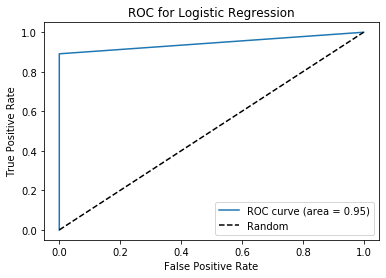

In [26]:
plot_roc(Y_test,regression_prediction, "Logistic Regression")

In [27]:
# install tensorflow in virtual enviroment locally or use google colab
# Please read this line at least.Basic model frame tuning may needed. I reached 0.7347 test accuracy for old dataset.
import tensorflow as tf
# Nerual network layer by layer. The input shape(...,62) may vary if new added
NN_model = tf.keras.models.Sequential()
NN_model.add(tf.keras.layers.Dense(units=128,activation="relu",input_dim=65)) 
# dropout exist for preventing overfitting. 
NN_model.add(tf.keras.layers.Dropout(0.2))
NN_model.add(tf.keras.layers.Dense(units=256,activation="relu"))
NN_model.add(tf.keras.layers.Dropout(0.2)) 
NN_model.add(tf.keras.layers.Dense(units=256,activation="relu")) 
# please do not change this line. sigmoid function is a must for binary classification
NN_model.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
# you can play with this line
NN_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy']) 

In [28]:
# a basic summary of model
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               8448      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 107,521
Trainable params: 107,521
Non-trainable params: 0
__________________________________________________

In [29]:
# I added early stop here.
earlyStopping=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=0, mode='min')
NN_model.fit(x=X_train,y=Y_train,batch_size=30,epochs=50,callbacks=[earlyStopping])

Train on 232 samples
Epoch 1/50
232/232 [==============================] - 1s 2ms/sample - loss: 0.7060 - accuracy: 0.5474
Epoch 2/50
232/232 [==============================] - 0s 60us/sample - loss: 0.6864 - accuracy: 0.5603
Epoch 3/50
232/232 [==============================] - 0s 56us/sample - loss: 0.6779 - accuracy: 0.5776
Epoch 4/50
232/232 [==============================] - 0s 60us/sample - loss: 0.6647 - accuracy: 0.6164
Epoch 5/50
232/232 [==============================] - 0s 64us/sample - loss: 0.6489 - accuracy: 0.6250
Epoch 6/50
232/232 [==============================] - 0s 64us/sample - loss: 0.6438 - accuracy: 0.6250
Epoch 7/50
232/232 [==============================] - 0s 82us/sample - loss: 0.6383 - accuracy: 0.6250
Epoch 8/50
232/232 [==============================] - 0s 73us/sample - loss: 0.6254 - accuracy: 0.6767
Epoch 9/50
232/232 [==============================] - 0s 56us/sample - loss: 0.6254 - accuracy: 0.6336
Epoch 10/50
232/232 [==============================] 

In [30]:
test_loss, test_accuracy = NN_model.evaluate(X_test, Y_test)

98/98 [==============================] - 0s 1ms/sample - loss: 0.7271 - accuracy: 0.6122


In [31]:
NN_prediction = NN_model.predict_classes(X_test)
print(confusion_matrix(Y_test,NN_prediction))

[[31 12]
 [26 29]]


In [32]:
print(classification_report(Y_test,NN_prediction))

              precision    recall  f1-score   support

           0       0.54      0.72      0.62        43
           1       0.71      0.53      0.60        55

    accuracy                           0.61        98
   macro avg       0.63      0.62      0.61        98
weighted avg       0.64      0.61      0.61        98



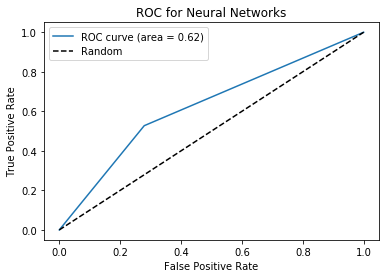

In [33]:
plot_roc(Y_test,NN_prediction, "Neural Networks")

### Backtesting

In [34]:
btc

,Close,Close_Past_1,Close_Past_2,Close_Past_3,Close_Past_4,Close_Past_5,Close_Past_6,Close_Past_7,Close_Past_8,Close_Past_9,...,Open_Past_25,Open_Past_26,Open_Past_27,Open_Past_28,Open_Past_29,Open_Past_30,MonthTrend,negative,neutral,positive
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-11,10410.126953,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,10623.5,...,10233,10358.7,10319.4,10038.4,10889.5,11385.1,UP,0.0484984,0.888504,0.0629979
2019-09-12,10360.546875,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,10594.5,...,10350.3,10233,10358.7,10319.4,10038.4,10889.5,UP,0.0588,0.8413,0.0999
2019-09-13,10358.048828,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,10575.5,...,10916.3,10350.3,10233,10358.7,10319.4,10038.4,DOWN,0.0439319,0.879837,0.0762308
2019-09-14,10347.712891,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,10353.3,...,10764.6,10916.3,10350.3,10233,10358.7,10319.4,UP,0.0253,0.9104,0.0643
2019-09-15,10276.793945,10347.7,10358,10360.5,10410.1,10178.4,10116,10335,10441.3,10517.3,...,10142.5,10764.6,10916.3,10350.3,10233,10358.7,DOWN,0.0291676,0.881429,0.089403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-04,11747.022461,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,10990.9,...,9277.51,9273.36,9427.99,9253.02,9349.16,9072.85,UP,0.05575,0.8895,0.05475
2020-08-05,11779.773438,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,10912.8,...,9241.05,9277.51,9273.36,9427.99,9253.02,9349.16,UP,0.022,0.902368,0.0756316
2020-08-06,11601.472656,11779.8,11747,11246.3,11246.3,11053.6,11759.6,11323.5,11111.2,11100.5,...,9277.21,9241.05,9277.51,9273.36,9427.99,9253.02,UP,0.0257778,0.895,0.0792222


In [37]:
portfolio_value = 100
portfolio_value_history = []
for i in range(0, len(btc) - LOOK_BACK_DAYS - LOOK_AHEAD_DAYS - 1):
    portfolio_value_history.append(portfolio_value)
    train_df = btc[i: i + LOOK_BACK_DAYS]
    X_TRAIN = train_df.drop(['MonthTrend'], axis=1)
    Y_TRAIN = le.fit_transform(train_df['MonthTrend'])
    test_df = btc[i + LOOK_BACK_DAYS + LOOK_AHEAD_DAYS : i + LOOK_BACK_DAYS + LOOK_AHEAD_DAYS + 1]
    X_TEST = test_df.drop(['MonthTrend'], axis=1)
    results_df = btc[i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS : i + LOOK_BACK_DAYS + 2*LOOK_AHEAD_DAYS + 1]
    
    model_regression = LogisticRegression()
    param_grid = {'C': [1,2,4]}  #simplified the CV so it runs faster
    regression_grid =  GridSearchCV(model_regression, param_grid, cv=TimeSeriesSplit(max_train_size=None, n_splits=10), verbose=1,n_jobs=6)
    regression_grid.fit(X_TRAIN,Y_TRAIN)
    model_regresssion= regression_grid.best_estimator_
    
    prediction = model_regresssion.predict(X_TEST)[0]
    if prediction == 1:
        gains = ((results_df['Close'] - results_df['Open']) / results_df['Open'])[0]
        if gains > 0:
            print("GAIN! " + str(1 + gains))
        elif gains < 0:
            print("LOSS! " + str(1 + gains))
        portfolio_value = portfolio_value * (1 + gains)
    print("portfolio value: " + str(portfolio_value))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0064722484464586
portfolio value: 100.64722484464585
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100.64722484464585
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 100.64722484464585
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100.64722484464585
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9842331661233105
portfolio value: 99.0603367703705
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0018506645601595
portfolio value: 99.24366422494889
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0280415609527733
portfolio value: 102.02661148448937
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0022620313782649
portfolio value: 102.25739888108532
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9799598258266199
portfolio value: 100.20814279699157
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100.20814279699157
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 100.20814279699157
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 100.20814279699157
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0666155602568346
portfolio value: 106.88356437171004
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0335444319379241
portfolio value: 110.4689128220596
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.4689128220596
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 110.4689128220596
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.4689128220596
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 110.4689128220596
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.4689128220596
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 110.4689128220596
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.4689128220596
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 110.4689128220596
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9925127480608039
portfolio value: 109.64180424031174
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0021428022555043
portfolio value: 109.87674494573545
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.87674494573545
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.87674494573545
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.87674494573545
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.87674494573545
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.87674494573545
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 109.87674494573545
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 109.87674494573545
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9882157801978252
portfolio value: 108.5819332321474
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 108.5819332321474
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 108.5819332321474
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 108.5819332321474
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 108.5819332321474
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9880809570698097
portfolio value: 107.28774050851038
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.28774050851038
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.28774050851038
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.28774050851038
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.28774050851038
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.28774050851038
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 107.28774050851038
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.28774050851038
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0430394464188195
portfolio value: 111.90534546752262
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9902194357285534
portfolio value: 110.81084804385908
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0394438687204568
portfolio value: 115.18165658690354
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 115.18165658690354
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9805426310097526
portfolio value: 112.9405245937842
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 112.9405245937842
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 112.9405245937842
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 112.9405245937842
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0268936188890219
portfolio value: 115.97790401933564
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 115.97790401933564
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 115.97790401933564
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 115.97790401933564
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9787225139842252
portfolio value: 113.51018578842535
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9839107086642968
portfolio value: 111.68388733970556
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9917866038777885
portfolio value: 110.76658333251612
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0036575395972402
portfolio value: 111.1717164971058
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 111.1717164971058
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 111.1717164971058
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 111.1717164971058
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9690812085318505
portfolio value: 107.73442137757556
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9580454394380576
portfolio value: 103.21447107128425
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 103.21447107128425
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 103.21447107128425
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0014121515478125
portfolio value: 103.36022554636422
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 103.36022554636422
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 103.36022554636422
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 103.36022554636422
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9956677812083113
portfolio value: 102.91244643493908
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.91244643493908
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.91244643493908
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.91244643493908
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.91244643493908
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.014349607801453
portfolio value: 104.38919967916848
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9828472843381522
portfolio value: 102.59864141890385
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.986175791690628
portfolio value: 101.18029642767036
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 101.18029642767036
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9698605332244129
portfolio value: 98.13077624514453
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 98.13077624514453
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 98.13077624514453
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0001168245467282
portfolio value: 98.14224032859946
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 98.14224032859946
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 98.14224032859946
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9899444496425026
portfolio value: 97.15536608877761
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9748555841151165
portfolio value: 94.71245115839328
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 94.71245115839328
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9847279582693808
portfolio value: 93.26599865189306
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0198216400074884
portfolio value: 95.11468370210979
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9944348100446602
portfolio value: 94.58535241976548
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0843676681862628
portfolio value: 102.56529804799699
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9979226862622207
portfolio value: 102.35223774534245
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9899352624966742
portfolio value: 101.32208933955758
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 101.32208933955758
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0017470941473823
portfolio value: 101.49910856884327
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9736955059174054
portfolio value: 98.82922586810551
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 98.82922586810551
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 98.82922586810551
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9927569266809558
portfolio value: 98.11339853907845
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9684200200112814
portfolio value: 95.01497937658917
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 95.01497937658917
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 95.01497937658917
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 95.01497937658917
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 95.01497937658917
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.050049279975456
portfolio value: 99.77041068127025
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 99.77041068127025
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0207144931952605
portfolio value: 101.83710417441577
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 101.83710417441577
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.004977081019406
portfolio value: 102.34395569267353
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.34395569267353
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.34395569267353
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.34395569267353
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 102.34395569267353
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 102.34395569267353
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0071910763540914
portfolio value: 103.0799188924393
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0073571235400032
portfolio value: 103.83829059022447
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.025626723407693
portfolio value: 106.4993257423078
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9744009967627031
portfolio value: 103.77304915786053
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0357496552119791
portfolio value: 107.4828998855498
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 107.4828998855498
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9893857546196765
portfolio value: 106.34205001197583
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 106.34205001197583
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 106.34205001197583
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 106.34205001197583
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 106.34205001197583
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0465127340076705
portfolio value: 111.28830949801326
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 111.28830949801326
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9978347798052194
portfolio value: 111.04734580284517
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 111.04734580284517
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9974684008769168
portfolio value: 110.76621843958998
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.027029769268814
portfolio value: 113.76020376679114
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 113.76020376679114
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.967920692457632
portfolio value: 110.1108552040738
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 110.1108552040738
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.1108552040738
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 110.1108552040738
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.1108552040738
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 110.1108552040738
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.1108552040738
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 110.1108552040738
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 110.1108552040738
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 110.1108552040738
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0048728575626913
portfolio value: 110.64740971758938
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9767972207968315
portfolio value: 108.08008230050963
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 108.08008230050963
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 108.08008230050963
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 108.08008230050963
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 108.08008230050963
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 108.08008230050963
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 108.08008230050963
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 108.08008230050963
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0367709261874887
portfolio value: 112.05428702911937
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 112.05428702911937
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 112.05428702911937
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 112.05428702911937
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.180305294438141
portfolio value: 132.25826824496068
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0011506637707783
portfolio value: 132.41045304261604
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9965431396348158
portfolio value: 131.95272859555695
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 131.95272859555695
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 131.95272859555695
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 131.95272859555695
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9914443935942692
portfolio value: 130.82379298553113
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 130.82379298553113
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 130.82379298553113
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9652000583468278
portfolio value: 126.27113262278796
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0851067318758851
portfolio value: 137.01765605057992
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0012499732343842
portfolio value: 137.1889244532812
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 137.1889244532812
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0282812878999854
portfolio value: 141.0688039224338
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9905832655942777
portfolio value: 139.74039646296333
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0191655082300208
portfolio value: 142.41859218144063
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9895944900688941
portfolio value: 140.93665410612252
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0712622121567903
portfolio value: 150.9801118517012
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 150.9801118517012
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0215641903665413
portfolio value: 154.23587572523297
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 154.23587572523297
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 154.23587572523297
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9987830368591373
portfolio value: 154.04817634947668
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.016480432667871
portfolio value: 156.58695694741255
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 156.58695694741255
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9998752055024313
portfolio value: 156.56741575679447
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 156.56741575679447
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0717345666984077
portfolio value: 167.79871148519757
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9971379170754802
portfolio value: 167.31845765829937
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0233173629517578
portfolio value: 171.21988286404624
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9901531024549559
portfolio value: 169.53389821980952
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9575733401219685
portfolio value: 162.34114118224085
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 162.34114118224085
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 162.34114118224085
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.043309254009497
portfolio value: 169.37201490189415
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0157003479230886
portfolio value: 172.03121446428844
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0025764080564745
portfolio value: 172.47443707119933
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0144948494370194
portfolio value: 174.97442806828104
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 174.97442806828104
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 174.97442806828104
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.1273680433386057
portfolio value: 197.2605786056296
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9841871527151077
portfolio value: 194.1413272008093
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0221364228899927
portfolio value: 198.43892172015086
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0134782146716854
portfolio value: 201.11352410631284
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9904108184812606
portfolio value: 199.185010017784
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 199.185010017784
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 199.185010017784
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0290116028197172
portfolio value: 204.96368641606134
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.074458089739114
portfolio value: 220.22489097248805
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 220.22489097248805
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9748996932447151
portfolio value: 214.69717865392946
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 214.69717865392946
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 214.69717865392946
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 214.69717865392946
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 214.69717865392946
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 214.69717865392946
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 214.69717865392946
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 214.69717865392946
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 214.69717865392946
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 214.69717865392946
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.000203001592388
portfolio value: 214.7407625230774
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9791937471589017
portfolio value: 210.27281192273202
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9536920566169427
portfolio value: 200.53551045321788
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 200.53551045321788
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 200.53551045321788
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9542008175650334
portfolio value: 191.3511480252818
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0137520681953733
portfolio value: 193.98262206218845
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9916344930451488
portfolio value: 192.35985908820695
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0388844527828014
portfolio value: 199.83966694622865
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0371048114569272
portfolio value: 207.2546801098836
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9906351683031609
portfolio value: 205.3137749122723
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0277044581896255
portfolio value: 211.0018818050835
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 211.0018818050835
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0743546514339681
portfolio value: 226.69085317861183
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9376983602682263
portfolio value: 212.56764131338954
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0128970124775534
portfolio value: 215.30912883573242
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 215.30912883573242
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9862571784482186
portfolio value: 212.35017389967345
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9988386217772866
portfolio value: 212.10355503211696
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0109654591577366
portfolio value: 214.42936790203237
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0011706666946827
portfolio value: 214.68039322139714
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 214.68039322139714
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 214.68039322139714
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9444485780096092
portfolio value: 202.75459210449227
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.017182559759993
portfolio value: 206.23843499994072
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 206.23843499994072
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9904230956881571
portfolio value: 204.26330924252207
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0068897027457264
portfolio value: 205.67062272506143
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0088592606946538
portfolio value: 207.49271238901454
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 207.49271238901454
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 207.49271238901454
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9870062092283622
portfolio value: 204.79659549759208
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 204.79659549759208
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 204.79659549759208
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 204.79659549759208
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 204.79659549759208
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 204.79659549759208
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 204.79659549759208
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 204.79659549759208
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9866452943655268
portfolio value: 202.06159724977945
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 202.06159724977945
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 202.06159724977945
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 202.06159724977945
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 202.06159724977945
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 202.06159724977945
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 202.06159724977945
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 202.06159724977945
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 202.06159724977945
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0333550111628982
portfolio value: 208.8013640816389
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 208.8013640816389
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0189465158811635
portfolio value: 212.75742244222027
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 212.75742244222027
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0005877262208878
portfolio value: 212.88246555807805
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 212.88246555807805
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0038356349679378
portfolio value: 213.69900498703345
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9963792090365983
portfolio value: 212.92524556088844
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.000488244088642
portfolio value: 213.0292050533562
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 213.0292050533562
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


LOSS! 0.9934994498856212
portfolio value: 211.6443980300806
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 211.6443980300806
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0008585168499806
portfolio value: 211.82609831199343
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.003036853640908
portfolio value: 212.46938316989156
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 212.46938316989156
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 212.46938316989156
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0160300714098067
portfolio value: 215.87528255450252
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0056607392141264
portfolio value: 217.0972962318194
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 217.0972962318194
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.014427186018474
portfolio value: 220.2293993086636
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 220.2293993086636
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.1096043820812165
portfolio value: 244.36750653600717
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 244.36750653600717
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0171827594501375
portfolio value: 248.5664146182453
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0010253180716313
portfolio value: 248.82127425515398
Fitting 10 folds for each of 3 candidates, totalling 30 fits
portfolio value: 248.82127425515398
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


portfolio value: 248.82127425515398
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9400319326300404
portfolio value: 233.8999433175417
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0183433831596385
portfolio value: 238.1904595988331
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0484833799148676
portfolio value: 249.73873814366024
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


G A I N! 1.0025449082386875
portfolio value: 250.37430031588147
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9849373067625922
portfolio value: 246.60298903569273
Fitting 10 folds for each of 3 candidates, totalling 30 fits
G A I N! 1.0128822004898905
portfolio value: 249.7797781818568
Fitting 10 folds for each of 3 candidates, totalling 30 fits
LOSS! 0.9947529836248726
portfolio value: 248.46917959556092


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished


Text(0.5, 1.0, 'Trade Performance')

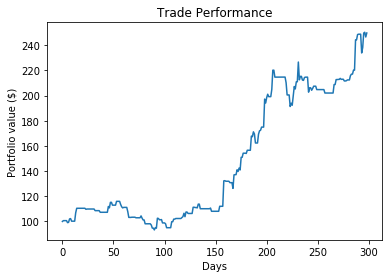

In [38]:
plt.plot(range(0, len(portfolio_value_history)), portfolio_value_history)
plt.xlabel('Days')
plt.ylabel('Portfolio value ($)')
plt.title("Trade Performance")